<a href="https://colab.research.google.com/github/yuvanarvind/Duke-AI-XAI/blob/wk3-churn-analysis/assignments/wk3_churn_interpretable_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# AIPI 590 - XAI | Assignment #02
### Wk3 Churn Analysis - Interpretable ML
### Yuvan Arvind


https://chatgpt.com/share/68c1d77c-ea68-8001-9ec4-fc66df38139f - ChatGPT Cited Link

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/XAI/WA_Fn-UseC_-Telco-Customer-Churn.csv')


## Dataset Basics

**Notes:**
- Checked the shape of the dataset (rows × columns)
- Churn distribution (Yes/No and 0/1)
- Class balance looks (balanced / slightly imbalanced / imbalanced).  
- I will train,test or consider class weights accordingly.


In [8]:
print(df.shape)
print(df['Churn'].value_counts())
df.head()


(7043, 21)
Churn
No     5174
Yes    1869
Name: count, dtype: int64


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 1. Exploratory Data Analysis

*  It tells us which features actually connect to churn.
*  It helps us see if a model’s assumptions (straight line vs curve) will hold.
*  It prevents us from blindly fitting models that don’t make sense.


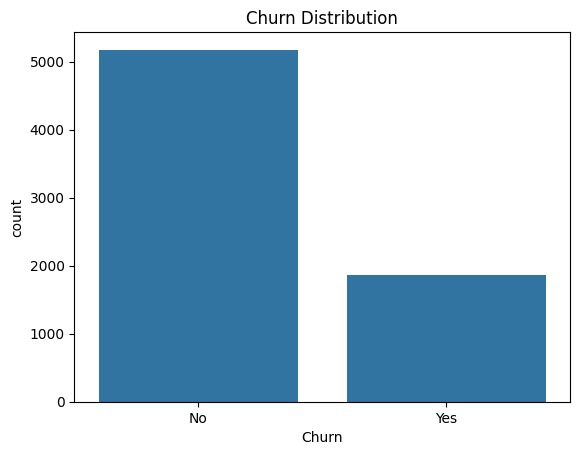

/tmp/ipython-input-2719259143.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tenure_churn = df.groupby(tenure_bins)['Churn_num'].mean().reset_index()


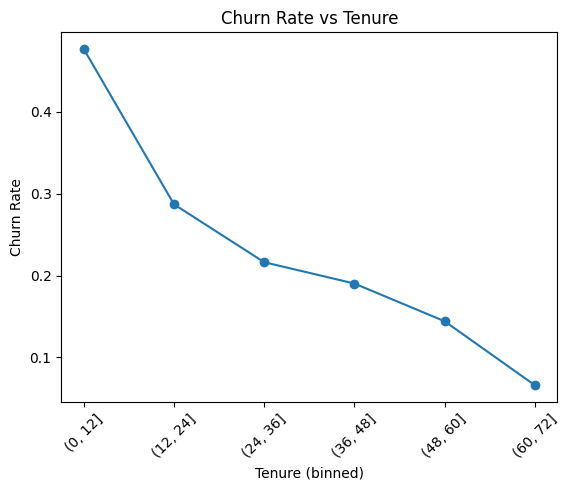

/tmp/ipython-input-2719259143.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  charges_churn = df.groupby(charges_bins)['Churn_num'].mean().reset_index()


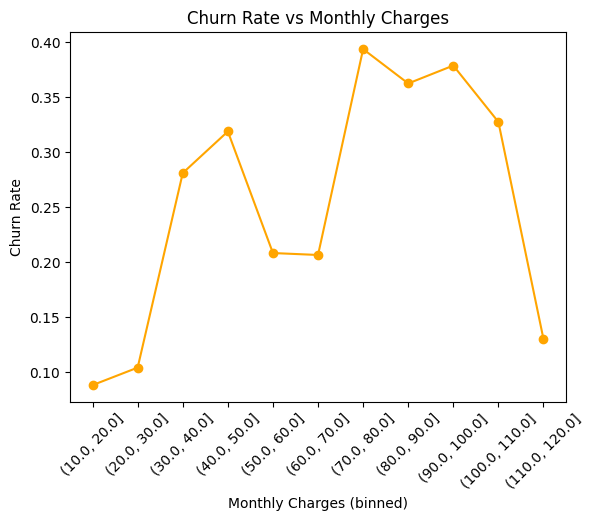

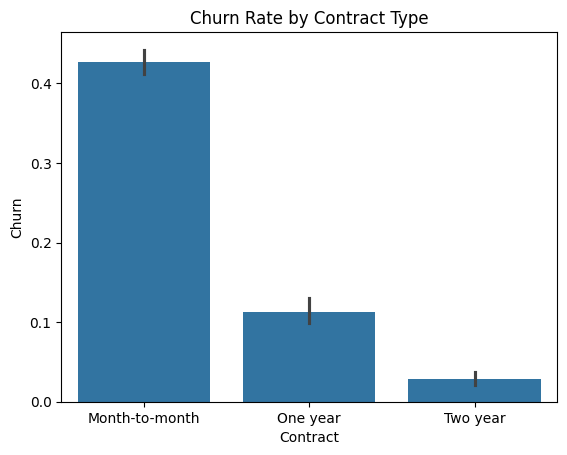

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Target distribution
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()

# Make a numeric churn column
df['Churn_num'] = df['Churn'].apply(lambda x: 1 if x=="Yes" else 0)

# Bin tenure into groups (e.g., every 12 months)
tenure_bins = pd.cut(df['tenure'], bins=np.arange(0, df['tenure'].max()+12, 12))
tenure_churn = df.groupby(tenure_bins)['Churn_num'].mean().reset_index()

plt.plot(tenure_churn['tenure'].astype(str), tenure_churn['Churn_num'], marker='o')
plt.xticks(rotation=45)
plt.ylabel("Churn Rate")
plt.xlabel("Tenure (binned)")
plt.title("Churn Rate vs Tenure")
plt.show()

# Bin monthly charges (e.g., in $10 intervals)
charges_bins = pd.cut(df['MonthlyCharges'], bins=np.arange(0, df['MonthlyCharges'].max()+10, 10))
charges_churn = df.groupby(charges_bins)['Churn_num'].mean().reset_index()

plt.plot(charges_churn['MonthlyCharges'].astype(str), charges_churn['Churn_num'], marker='o', color='orange')
plt.xticks(rotation=45)
plt.ylabel("Churn Rate")
plt.xlabel("Monthly Charges (binned)")
plt.title("Churn Rate vs Monthly Charges")
plt.show()


# Categorical vs churn
sns.barplot(x='Contract', y=df['Churn'].apply(lambda x: 1 if x=="Yes" else 0), data=df)
plt.title("Churn Rate by Contract Type")
plt.show()


# EDA Learnings

I first checked the churn distribution. Most customers stay, fewer leave(based on Yes/No). That means the data is imbalanced, so accuracy alone won’t be a good measure later.

Then I looked at how churn changes with some key features:

- Tenure vs Churn: The line plot shows that new customers churn a lot in the first year. After that, churn rate drops and stays lower. This is not a straight-line pattern, which means simple linear models may not capture it well. GAM will be useful here since it can handle curves.

- Monthly Charges vs Churn: as monthly charges go up, churn rate goes up too. The line looks more straight, so both linear and logistic models can handle this feature reasonably well.

- Contract Type vs Churn: customers on month-to-month contracts churn much more than those on one or two year contracts. This is a clear categorical driver of churn.

**Purpose**  
The goal was to check if the assumptions of linear, logistic, and GAM models make sense for this dataset.  
- Linear regression assumes straight-line relationships, but that doesn’t fit well for tenure.  
- Logistic regression is better, but still assumes straight log-odds, so it may also miss the tenure curve.  
- GAM is designed to capture the curve we saw with tenure.  

**Learnings**  
EDA gave me a quick picture of which features matter and how they behave. Tenure is curved, Monthly Charges are closer to linear, and Contract type is a strong categorical predictor. This sets expectations for the three models we’ll fit next.

- Linear regression: Assumes linearity; not great for binary churn (predictions outside 0–1). We will still fit it as a baseline.
- Logistic regression: Assumes log-odds are linear in features. Might be okay for MonthlyCharges, but tenure violates this because its non-inear.
- GAM: Handles non-linearity by design, so suitable for features like tenure.

**Conclusion**  
We will keep all three models, but expect GAM to capture non-linear effects best, logistic to be used to be realistic, and linear to serve only as a baseline for certain data points.



# Testing the Assumptions for Linear Regression

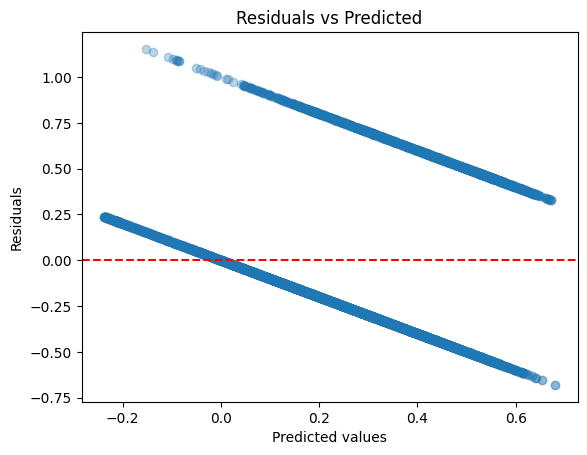

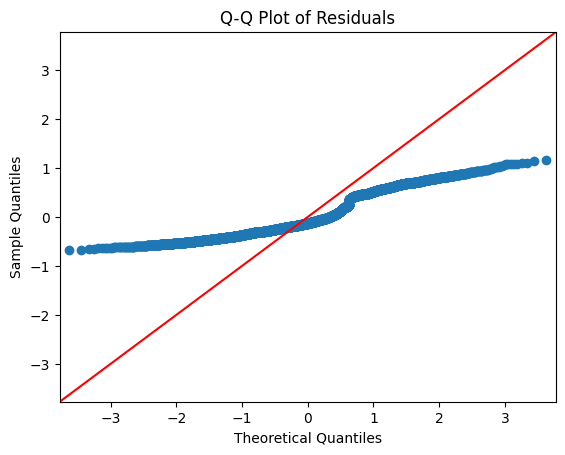

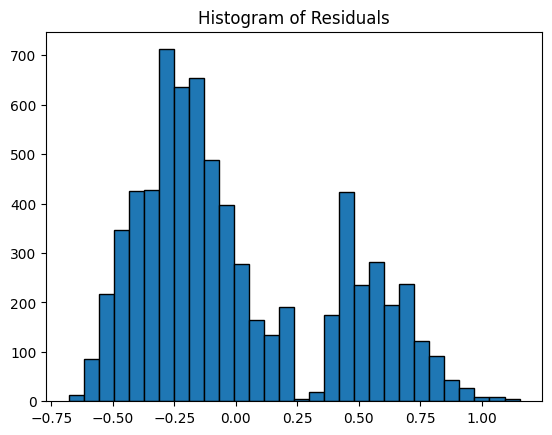

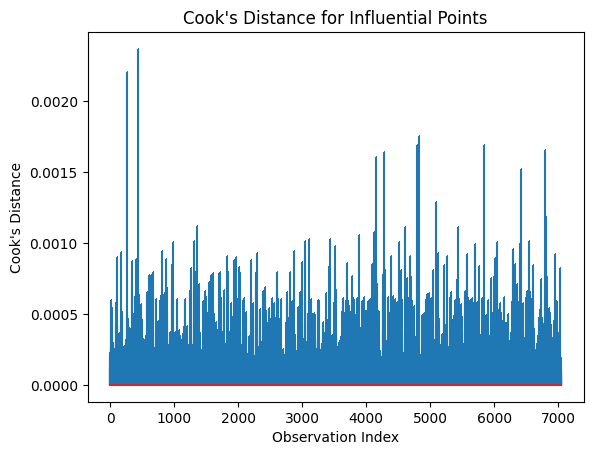

Number of influential points: 241
Durbin-Watson: 2.0108312192805773


In [26]:
import statsmodels.api as sm

# Define features (X) and target (y)
# Exclude non-numeric and target columns
X = df.select_dtypes(include=np.number).drop(['Churn_num', 'SeniorCitizen'], axis=1)
y = df['Churn_num']

# Add a constant to the features for the OLS model
X = sm.add_constant(X)

# Create and fit the OLS model
ols_model = sm.OLS(y, X).fit()


# Predicted vs residuals
y_pred = ols_model.predict(X)
residuals = y - y_pred

plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()

#Q-Q Plot (Normality of residuals)
import statsmodels.api as sm

sm.qqplot(residuals, line='45')
plt.title("Q-Q Plot of Residuals")
plt.show()

plt.hist(residuals, bins=30, edgecolor='k')
plt.title("Histogram of Residuals")
plt.show()


#Multicollinearity (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data.sort_values("VIF", ascending=False).head(10)


#Outliers / Influential Points (Cook’s Distance)
influence = ols_model.get_influence()
cooks = influence.cooks_distance[0]

plt.stem(np.arange(len(cooks)), cooks, markerfmt=",")
plt.title("Cook's Distance for Influential Points")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.show()

# Flag potential outliers
influential_points = np.where(cooks > 4 / len(X))[0]
print("Number of influential points:", len(influential_points))


#Independence (Durbin–Watson statistic)
from statsmodels.stats.stattools import durbin_watson
print("Durbin-Watson:", durbin_watson(residuals))




# 2. Linear Regression

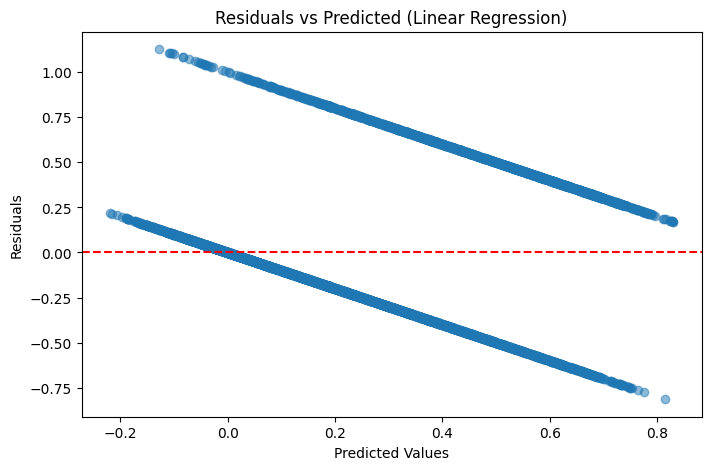

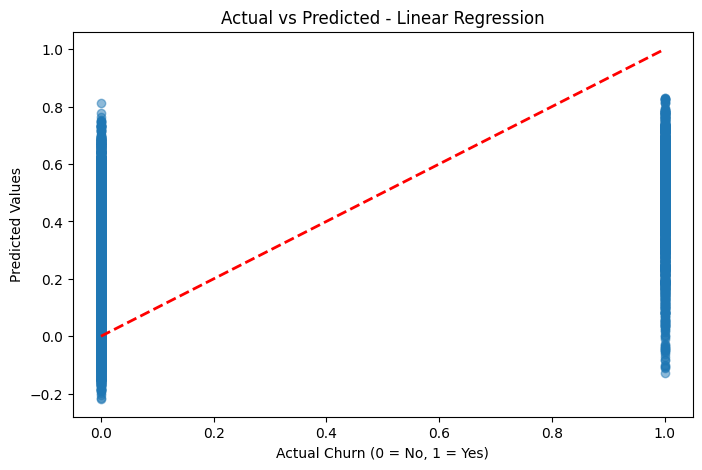

In [35]:
import matplotlib.pyplot as plt

# Predicted values from the OLS model
y_pred = ols_model.predict(X)

# Residuals = actual - predicted
residuals = y - y_pred

# Plot residuals vs predicted
plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted (Linear Regression)")
plt.show()


# Actual vs Predicted values
plt.figure(figsize=(8,5))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)  # perfect predictions line
plt.xlabel("Actual Churn (0 = No, 1 = Yes)")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted - Linear Regression")
plt.show()



## Linear Regression Interpretation

**Learnings:**
- MonthlyCharges (positive): higher monthly bills are linked to higher churn. Customers paying more are more likely to leave.  
- Tenure (negative): The longer a customer has stayed, the less likely they are to churn.  
- Contract type (negative for one and two year contracts): longer contracts reduce churn compared to month-to-month contracts.  

**Problems:**
- The residual and actual-vs-predicted plots show violations of assumptions. Predictions sometimes fall below 0 or above 1, which makes no sense for churn probability.  
- Residuals are not normally distributed, which further breaks the assumptions.  

**Conclusion:**  
Linear regression is not reliable for churn prediction because its assumptions don’t hold for binary outcomes. It’s only useful here as a baseline.

# 3. Logistic Regression

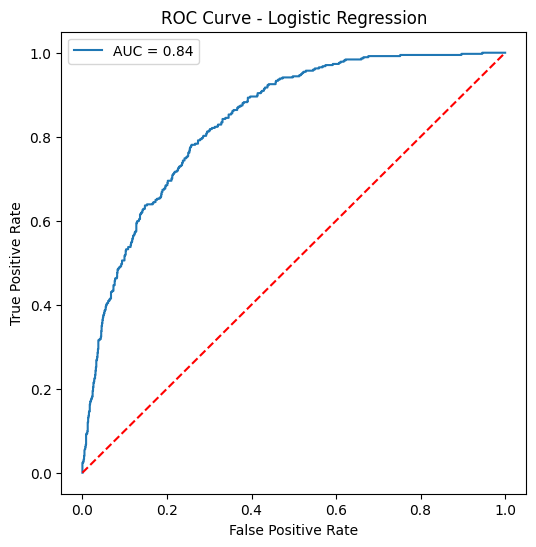

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score

# Prepare features (one-hot encode categoricals)
X = df.drop(columns=['customerID', 'Churn', 'Churn_num'])
X = pd.get_dummies(X, drop_first=True)
y = df['Churn_num']

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Fit logistic regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

# Predict probabilities
y_pred_prob = log_model.predict_proba(X_test)[:,1]


fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1],[0,1],'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()


# Logistic Regression Explanation

Logistic regression is better suited for churn than linear regression because the target is binary (0/1). Instead of predicting raw numbers, the model predicts the probability of churn, always between 0 and 1.

- The model assigns a weight (coefficient) to each feature.
  - Positive coefficient - increases the odds of churn.
  - Negative coefficient - decreases the odds of churn.
- These weights can be converted into odds ratios, which are easier to explain

Results from my graph:
- The ROC curve had an AUC around ~0.8, which means the model did a good job separating churners from non-churners.
- The actual vs predicted probabilities plot shows that churners (1s) tend to have higher predicted probabilities, and non-churners (0s) tend to have lower probabilities. There is some overlap, which explains misclassifications.

Conclusion:
- Logistic regression fixes the main issues we saw with linear regression: no more predictions below 0 or above 1.
- It gives interpretable results (coefficients and odds ratios) that a telecom manager can use to explain churn drivers.
- It is simple and it has performance and interpretability.


# 4. GAM

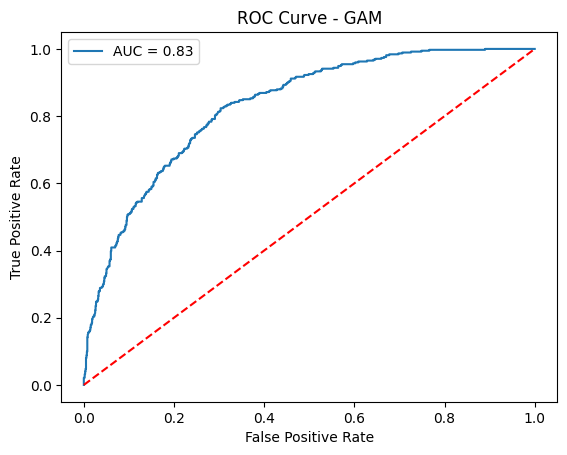

In [41]:
from pygam import LogisticGAM, s, f

# Build a GAM with splines for numeric features
# s() = spline term, f() = factor/categorical term
gam = LogisticGAM(
    s(0) + s(1) + s(2)  # you can add as many numeric features as you want here
).fit(X_train, y_train)

# Predict probabilities
y_pred_prob_gam = gam.predict_proba(X_test)

# ROC Curve
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_gam)
auc = roc_auc_score(y_test, y_pred_prob_gam)

plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1],[0,1],'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - GAM")
plt.legend()
plt.show()


In [40]:
!pip install pygam

## GAM Explanation

Logistic regression and GAM models look very similar
- Both had an AUC around ~0.8, showing good predictive performance.
- For features that are mostly linear, the GAM curves look almost identical to the logistic regression coefficients.

The main difference is with tenure:
- Logistic regression forces tenure into a straight line, which doesn’t match the actual churn pattern.
- GAM captures the curve: high churn early, then flattening out for long-term customers.

Learning:  
GAM makes the non-linear patterns more interpretable. In this dataset, tenure is the clearest example. GAM is still more valuable especially when there is atleast one feature thats non-linear.

# 5. Model Comparison

I tried three models to understand churn:

- Linear Regression: Quick baseline. It showed which features matter (like tenure and contract type), but predictions went outside 0–1 and most assumptions were violated. It’s not realistic for churn, but it gave me a starting point. I found the assumptions to be very challenging to understand. I'm not sure if I still do get it fully but this showed mainly where this is most powerfuk and least.

- Logistic Regression: Much better fit for churn. Outputs probabilities between 0–1, interpretable coefficients, and a solid AUC (~0.8). Easy to explain and easy to use. This was a very practical use case where nothing is over-engineered. Does the bare minimum to get the required results.

- GAM: Similar overall performance to logistic regression, but more flexible. It showed the churn curve for tenure clearly (new customers churn the most, then it levels off). That’s something logistic regression flattens. Its very similar to logistic regression in this case.

Takeaway:
- If I had to pick one model for the company, I’d recommend *Logistic Regression*. It’s simple, interpretable, and performs well.  
- I’d use GAM to explore non-linear effects like tenure, because those insights are useful for customer retention strategies.  
- Linear regression is just a starting point — not practical for churn prediction.  

**Learnings and Insights:**  
The real value here isn’t just accuracy, it’s being able to explain churn drivers in plain language:  
- High monthly charges push churn up.  
- Month-to-month contracts are risky.  
- Customers who survive the early months tend to stay.  

